# Predict students' dropout and academic success


## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, HeNormal




from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE

## Dataset

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes)
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets

# metadata
#print(predict_students_dropout_and_academic_success.metadata)

# variable information
#print(predict_students_dropout_and_academic_success.variables)


## Classe


In [5]:
tf.random.set_seed(42)
def create_mlp(num_hiddenlayers, num_neurons, learning_rate, batch_size, input_shape=(9,), activation='sigmoid', output_classes=3):
    model = Sequential()

    # Adicione a camada de entrada
    model.add(Dense(num_neurons[0], activation=activation, input_shape=input_shape))

    # Adicione camadas ocultas
    for i in range(1, num_hiddenlayers):
        model.add(Dense(num_neurons[i], activation=activation))

    # Adicione a camada de saída
    model.add(Dense(output_classes, activation='softmax'))

    # Compile o modelo com um otimizador personalizado
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

## EDA

In [6]:
X.head(3)

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74


In [7]:
y.sample(10)

,Target
1640,Graduate
311,Dropout
3990,Graduate
2008,Graduate
3655,Graduate
2060,Graduate
3431,Graduate
137,Graduate
2042,Graduate
1461,Graduate


In [8]:
data = pd.concat([X, y], axis=1); data.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [9]:
class_mapping = {'Dropout': 0, 'Graduate': 1, 'Enrolled': 2}
data['Target'] = [class_mapping[val] for val in data['Target']]

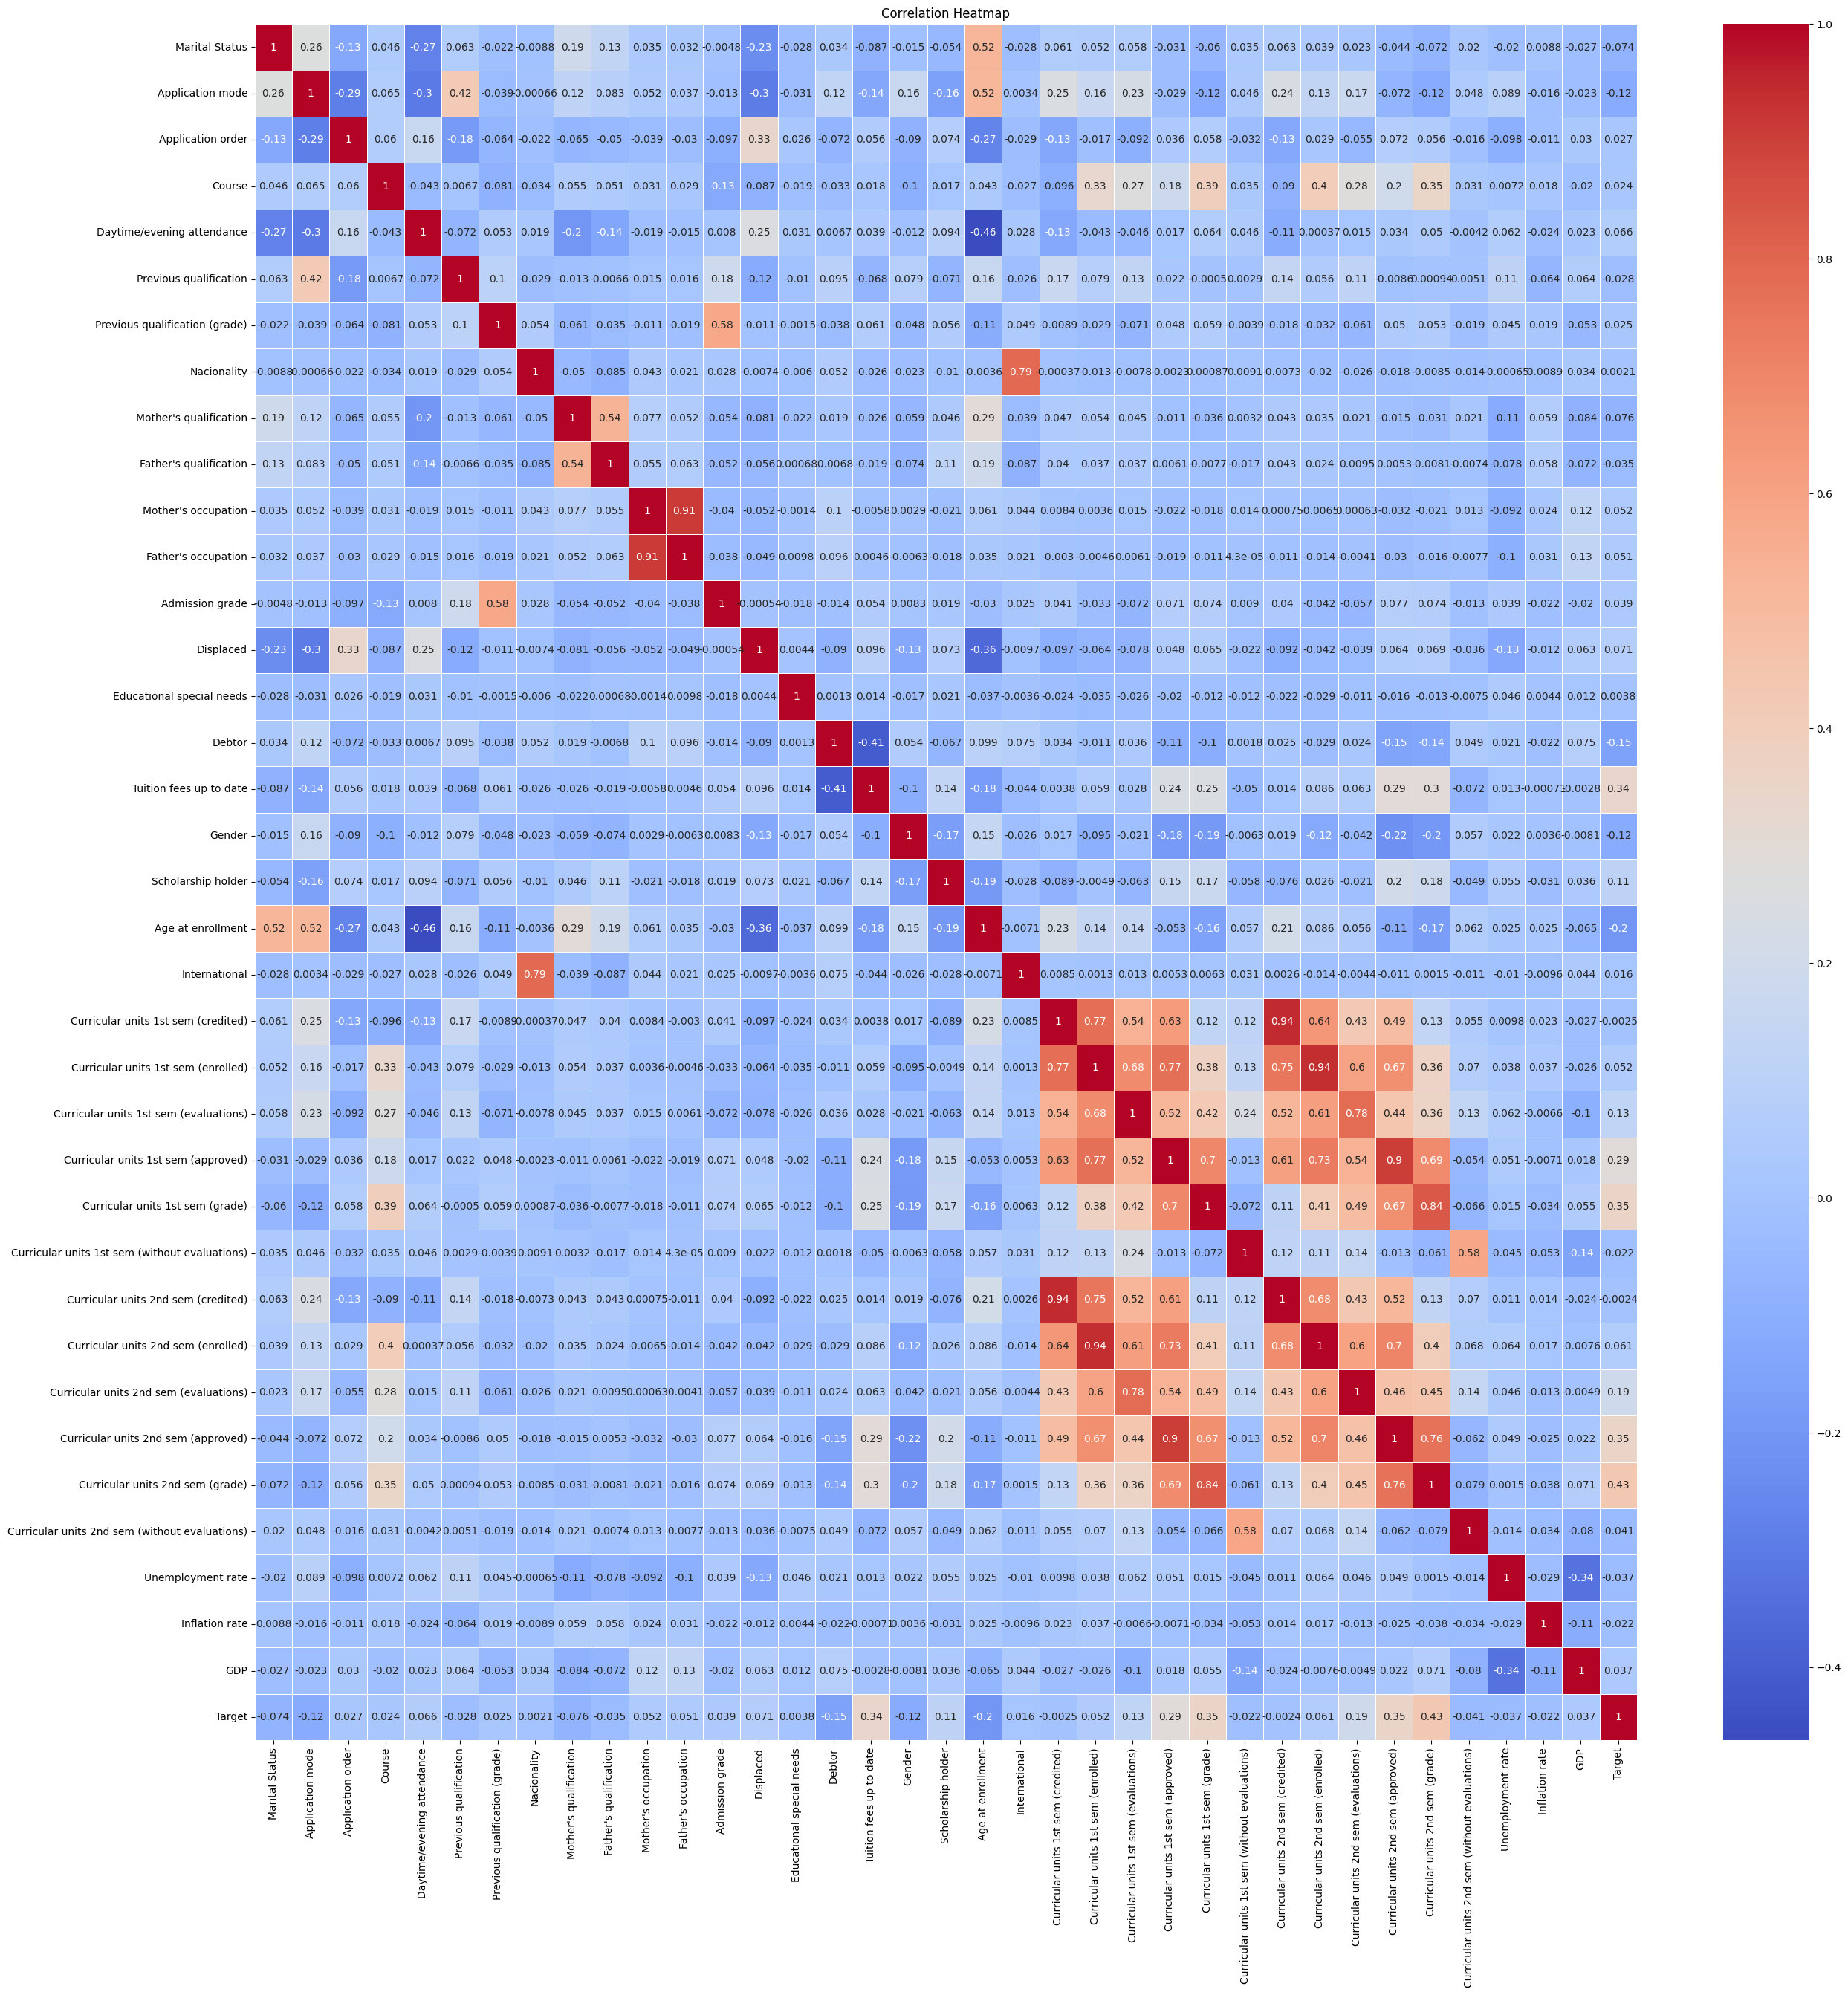

In [10]:
plt.figure(figsize=(30, 30))
sns.heatmap(data.corr() , annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [11]:
# Retirando Features com baixa correlação com a saida "Target"

X = X.copy()
X = X.drop(columns=['Nacionality','Mother\'s qualification',
'Father\'s qualification',
                                  'Educational special needs',
                                  'International',
                                  'Curricular units 1st sem (without evaluations)',
                                  'Unemployment rate',
                                  'Inflation rate'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Mother's occupation                             4424 non-null   int64  
 8   Father's occupation                             4424 non-null   int64  
 9   Admission grade                          

In [12]:
X.isnull().sum()/len(data)*100


Marital Status                                    0.0
Application mode                                  0.0
Application order                                 0.0
Course                                            0.0
Daytime/evening attendance                        0.0
Previous qualification                            0.0
Previous qualification (grade)                    0.0
Mother's occupation                               0.0
Father's occupation                               0.0
Admission grade                                   0.0
Displaced                                         0.0
Debtor                                            0.0
Tuition fees up to date                           0.0
Gender                                            0.0
Scholarship holder                                0.0
Age at enrollment                                 0.0
Curricular units 1st sem (credited)               0.0
Curricular units 1st sem (enrolled)               0.0
Curricular units 1st sem (ev

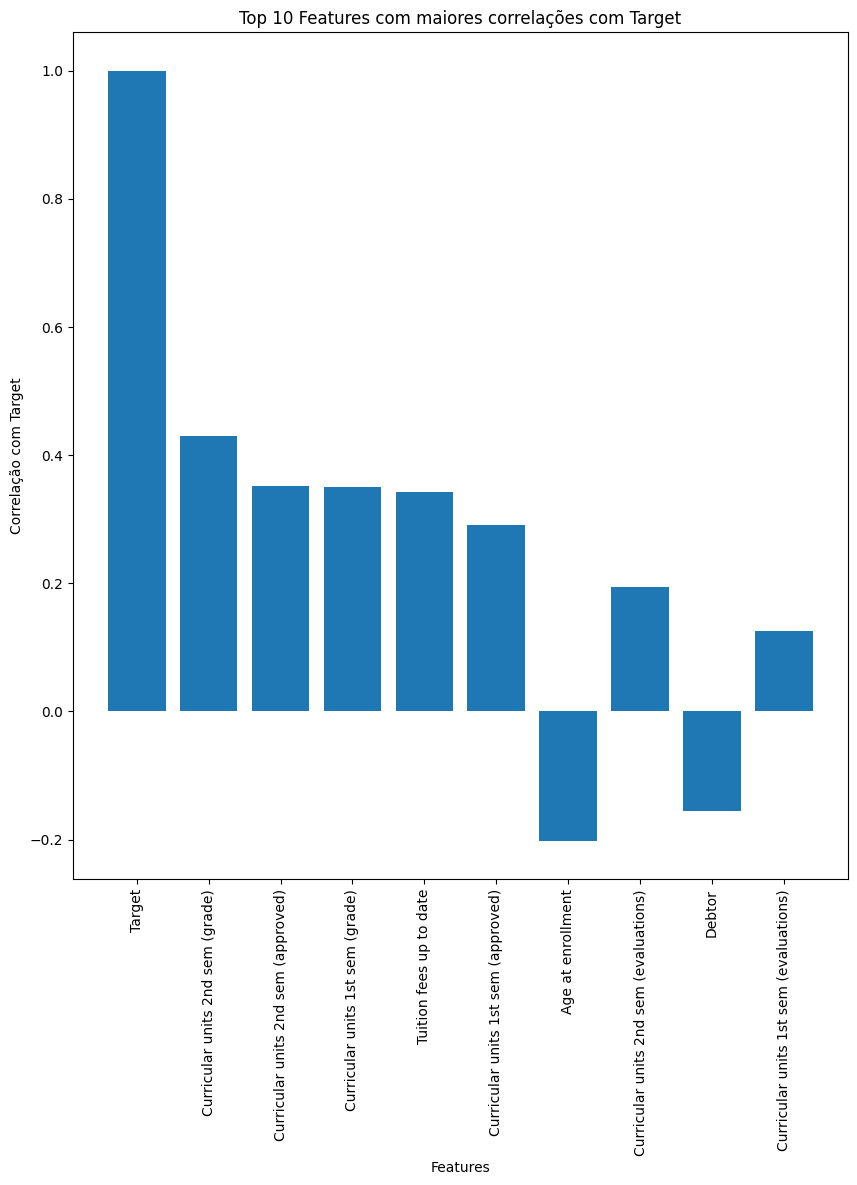

In [13]:
correlations = data.corr()['Target']
top_10_features = correlations.abs().nlargest(10).index
top_10_corr_values = correlations[top_10_features]

plt.figure(figsize=(10, 11))
plt.bar(top_10_features, top_10_corr_values)
plt.xlabel('Features')
plt.ylabel('Correlação com Target')
plt.title('Top 10 Features com maiores correlações com Target')
plt.xticks(rotation=90)
plt.show()

## Tratamento de Dados

In [14]:
X.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,...,Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),GDP
0,1,17,5,171,1,1,122.0,5,9,127.3,...,0,0,0.000000,0,0,0,0,0.000000,0,1.74
1,1,15,1,9254,1,1,160.0,3,3,142.5,...,6,6,14.000000,0,6,6,6,13.666667,0,0.79
2,1,1,5,9070,1,1,122.0,9,9,124.8,...,0,0,0.000000,0,6,0,0,0.000000,0,1.74
3,1,17,2,9773,1,1,122.0,5,3,119.6,...,8,6,13.428571,0,6,10,5,12.400000,0,-3.12
4,2,39,1,8014,0,1,100.0,9,9,141.5,...,9,5,12.333333,0,6,6,6,13.000000,0,0.79


In [15]:
y.head()

,Target
0,Dropout
1,Graduate
2,Dropout
3,Graduate
4,Graduate


precisamos converter categorizar os dados do TARGET

In [16]:
y.Target.unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

Temos 3 categorias:
- Dropout -> alunos desistentes
- Graduate -> alunos que concluiram a graduação
- Enrolled -> alunos que ainda estão cursando




In [17]:
# feature_selection = ['Marital Status','Application mode','Displaced','Age at enrollment',
#           'Curricular units 1st sem (enrolled)','Curricular units 1st sem (evaluations)','Curricular units 1st sem (approved)',
#           'Curricular units 2nd sem (enrolled)','Curricular units 2nd sem (approved)','Curricular units 2nd sem (grade)']

feature_selection = ['Tuition fees up to date','Debtor','Age at enrollment',
          'Curricular units 1st sem (evaluations)','Curricular units 1st sem (approved)','Curricular units 1st sem (grade)',
          'Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (approved)','Curricular units 2nd sem (grade)']



Seleção de features mais importantes do DATASET

In [18]:
X = X[feature_selection]

In [19]:
X.head()

,Tuition fees up to date,Debtor,Age at enrollment,Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade)
0,1,0,20,0,0,0.000000,0,0,0.000000
1,0,0,19,6,6,14.000000,6,6,13.666667
2,0,0,19,0,0,0.000000,0,0,0.000000
3,1,0,20,8,6,13.428571,10,5,12.400000
4,1,0,45,9,5,12.333333,6,6,13.000000


Reduzimos para 10 features

In [20]:
class_mapping = {'Dropout': 0, 'Graduate': 1, 'Enrolled': 2}
y['Target'] = [class_mapping[val] for val in y['Target']]

<ipython-input-20-bf1373b4d1de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Target'] = [class_mapping[val] for val in y['Target']]


In [21]:
y['Target']

0       0
1       1
2       0
3       1
4       1
       ..
4419    1
4420    0
4421    0
4422    1
4423    1
Name: Target, Length: 4424, dtype: int64

## Split - Treino Teste e Validação

In [22]:
X = X.values
y = y.values

In [23]:
# Divida o conjunto de dados em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
print(f'Dados de Entrada-Teste: {X_test.shape}')
print(f'Dados de Saida-Teste: {y_test.shape}')

Dados de Entrada-Teste: (885, 9)
Dados de Saida-Teste: (885, 1)


In [25]:
print(f'Dados de Entrada-Treinamento: {X_train.shape}')
print(f'Dados de Saida-Treinamento: {y_train.shape}')

print(f'Dados de Entrada-validação: {X_val.shape}')
print(f'Dados de Saida-validação: {y_val.shape}')

Dados de Entrada-Treinamento: (2654, 9)
Dados de Saida-Treinamento: (2654, 1)
Dados de Entrada-validação: (885, 9)
Dados de Saida-validação: (885, 1)


## Normalização

In [26]:
# Padronizar os dados (importante ao usar redes neurais)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_val_scaled = scaler.transform(X_val)

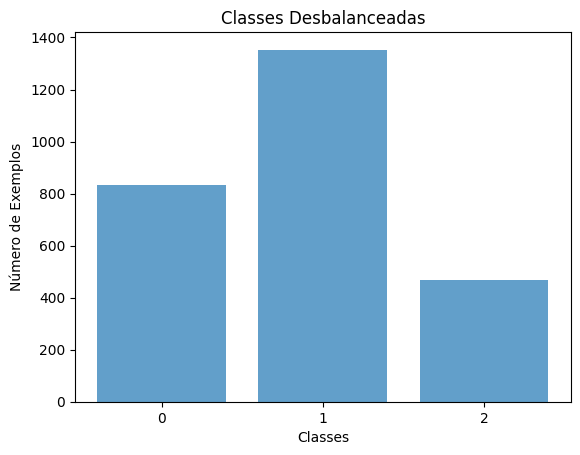

In [27]:
unique_classes, counts = np.unique(y_train, return_counts=True)

plt.bar(unique_classes, counts, align='center', alpha=0.7)
plt.xticks(unique_classes)
plt.xlabel('Classes')
plt.ylabel('Número de Exemplos')
plt.title('Classes Desbalanceadas')
plt.show()

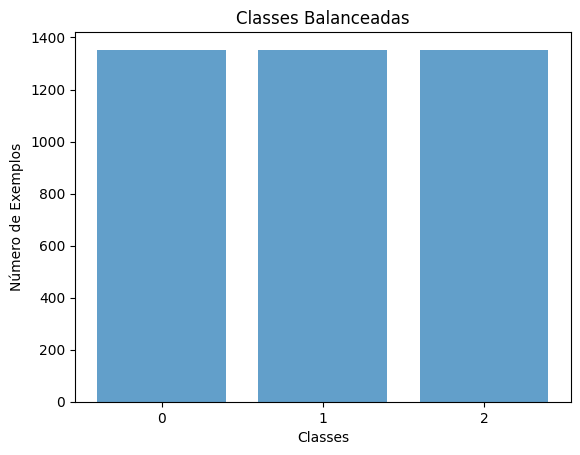

In [28]:
# Aplicar SMOTE para oversampling
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


unique_classes, counts = np.unique(y_train_balanced, return_counts=True)

plt.bar(unique_classes, counts, align='center', alpha=0.7)
plt.xticks(unique_classes)
plt.xlabel('Classes')
plt.ylabel('Número de Exemplos')
plt.title('Classes Balanceadas')
plt.show()

## Modelos

In [34]:
# randomstate para diferentes inicializações de pesos

#tf.random.set_seed(42)
#tf.random.set_seed(54)
tf.random.set_seed(99)

In [35]:
# Definir configurações dos modelos
model_configs = [
    {'num_hiddenlayers': 1, 'num_neurons': [256], 'learning_rate': 0.005, 'activation': 'tanh', 'batch_size': 16},
    {'num_hiddenlayers': 2, 'num_neurons': [128, 64], 'learning_rate': 0.01, 'activation': 'sigmoid', 'batch_size': 32},
    {'num_hiddenlayers': 3, 'num_neurons': [64, 32, 16], 'learning_rate': 0.001, 'activation': 'relu', 'batch_size': 64},
    {'num_hiddenlayers': 4, 'num_neurons': [32,24,12,5], 'learning_rate': 0.01, 'activation': 'tanh', 'batch_size': 64}
]

========== Treinando Modelo 1 ==========
Epoch 1/70
254/254 [==============================] - 2s 4ms/step - loss: 0.7774 - accuracy: 0.6716 - val_loss: 0.7456 - val_accuracy: 0.6814
Epoch 2/70
254/254 [==============================] - 1s 5ms/step - loss: 0.7401 - accuracy: 0.6896 - val_loss: 0.7086 - val_accuracy: 0.7028
Epoch 3/70
254/254 [==============================] - 1s 6ms/step - loss: 0.7287 - accuracy: 0.6891 - val_loss: 0.7044 - val_accuracy: 0.7017
Epoch 4/70
254/254 [==============================] - 1s 5ms/step - loss: 0.7197 - accuracy: 0.6938 - val_loss: 0.7390 - val_accuracy: 0.6802
Epoch 5/70
254/254 [==============================] - 1s 4ms/step - loss: 0.7078 - accuracy: 0.6970 - val_loss: 0.7143 - val_accuracy: 0.6994
Epoch 6/70
254/254 [==============================] - 1s 4ms/step - loss: 0.7013 - accuracy: 0.7110 - val_loss: 0.7144 - val_accuracy: 0.6904
Epoch 7/70
254/254 [==============================] - 1s 4ms/step - loss: 0.6937 - accuracy: 0.7071 - val_l

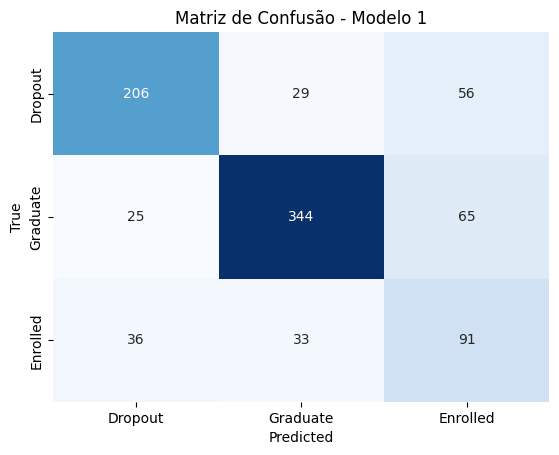

========== Treinando Modelo 2 ==========
Epoch 1/70
127/127 [==============================] - 2s 5ms/step - loss: 0.8126 - accuracy: 0.6396 - val_loss: 0.7130 - val_accuracy: 0.7028
Epoch 2/70
127/127 [==============================] - 1s 4ms/step - loss: 0.7289 - accuracy: 0.6997 - val_loss: 0.7389 - val_accuracy: 0.6836
Epoch 3/70
127/127 [==============================] - 1s 4ms/step - loss: 0.7174 - accuracy: 0.7019 - val_loss: 0.6788 - val_accuracy: 0.7085
Epoch 4/70
127/127 [==============================] - 1s 4ms/step - loss: 0.7012 - accuracy: 0.7024 - val_loss: 0.7375 - val_accuracy: 0.6633
Epoch 5/70
127/127 [==============================] - 1s 4ms/step - loss: 0.6944 - accuracy: 0.7108 - val_loss: 0.7181 - val_accuracy: 0.6780
Epoch 6/70
127/127 [==============================] - 1s 4ms/step - loss: 0.6901 - accuracy: 0.7100 - val_loss: 0.7220 - val_accuracy: 0.6712
Epoch 7/70
127/127 [==============================] - 1s 4ms/step - loss: 0.6857 - accuracy: 0.7120 - val_l

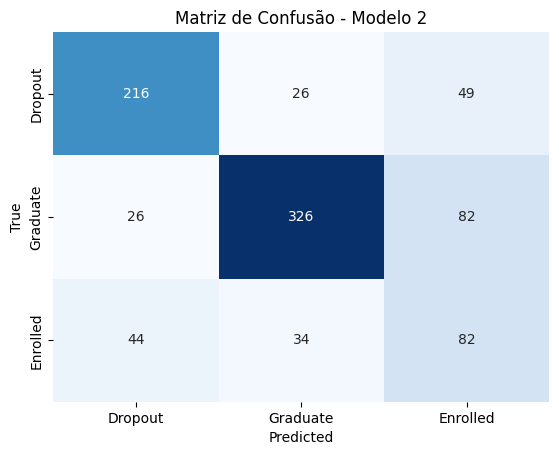

========== Treinando Modelo 3 ==========
Epoch 1/70
64/64 [==============================] - 2s 7ms/step - loss: 0.9210 - accuracy: 0.5849 - val_loss: 0.7554 - val_accuracy: 0.7266
Epoch 2/70
64/64 [==============================] - 0s 5ms/step - loss: 0.7505 - accuracy: 0.6866 - val_loss: 0.6881 - val_accuracy: 0.7164
Epoch 3/70
64/64 [==============================] - 0s 5ms/step - loss: 0.7037 - accuracy: 0.7058 - val_loss: 0.6877 - val_accuracy: 0.7232
Epoch 4/70
64/64 [==============================] - 0s 5ms/step - loss: 0.6860 - accuracy: 0.7199 - val_loss: 0.6912 - val_accuracy: 0.7164
Epoch 5/70
64/64 [==============================] - 0s 5ms/step - loss: 0.6755 - accuracy: 0.7226 - val_loss: 0.6785 - val_accuracy: 0.7153
Epoch 6/70
64/64 [==============================] - 0s 5ms/step - loss: 0.6679 - accuracy: 0.7275 - val_loss: 0.6733 - val_accuracy: 0.7254
Epoch 7/70
64/64 [==============================] - 0s 5ms/step - loss: 0.6641 - accuracy: 0.7307 - val_loss: 0.6836 - 

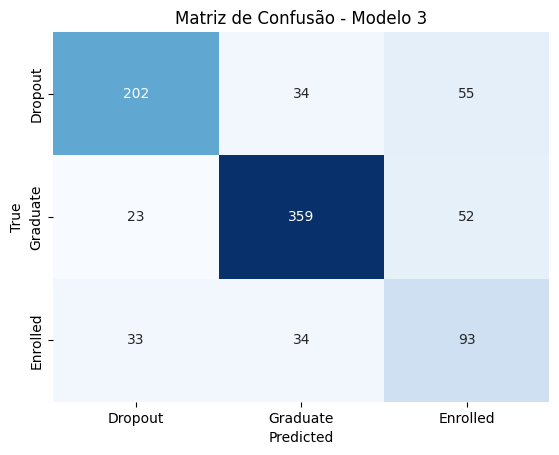

========== Treinando Modelo 4 ==========
Epoch 1/70
64/64 [==============================] - 2s 11ms/step - loss: 0.7922 - accuracy: 0.6679 - val_loss: 0.7442 - val_accuracy: 0.6870
Epoch 2/70
64/64 [==============================] - 1s 8ms/step - loss: 0.7169 - accuracy: 0.7009 - val_loss: 0.7262 - val_accuracy: 0.6893
Epoch 3/70
64/64 [==============================] - 0s 7ms/step - loss: 0.7094 - accuracy: 0.6994 - val_loss: 0.7103 - val_accuracy: 0.6904
Epoch 4/70
64/64 [==============================] - 0s 7ms/step - loss: 0.7021 - accuracy: 0.6997 - val_loss: 0.7382 - val_accuracy: 0.6678
Epoch 5/70
64/64 [==============================] - 0s 7ms/step - loss: 0.6872 - accuracy: 0.7058 - val_loss: 0.7072 - val_accuracy: 0.6983
Epoch 6/70
64/64 [==============================] - 0s 8ms/step - loss: 0.6834 - accuracy: 0.7090 - val_loss: 0.6964 - val_accuracy: 0.7107
Epoch 7/70
64/64 [==============================] - 0s 8ms/step - loss: 0.6741 - accuracy: 0.7194 - val_loss: 0.6962 -

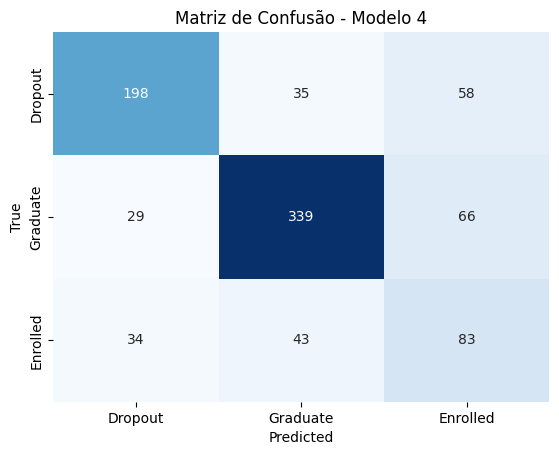

In [36]:
# Treinar cada modelo
for i, config in enumerate(model_configs):
    print(f'========== Treinando Modelo {i + 1} ==========')

    # Criar o modelo
    custom_model = create_mlp(**config)

    # Treinar o modelo
    model_fit = custom_model.fit(X_train_balanced, y_train_balanced, epochs=70, batch_size=config['batch_size'],
                                 validation_data=(X_val_scaled, y_val), verbose=1)

    # Avaliar o desempenho no conjunto de teste
    y_pred_probs = custom_model.predict(X_test_scaled)
    y_pred = tf.argmax(y_pred_probs, axis=1)  # Obtém a classe com a probabilidade mais alta

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f'Acurácia no conjunto de teste do Modelo {i + 1}: {accuracy * 100:.2f}%')
    print('Matriz de Confusão:')
    print(conf_matrix)

    # Plotar a matriz de confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Dropout', 'Graduate', 'Enrolled'], yticklabels=['Dropout', 'Graduate', 'Enrolled'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Matriz de Confusão - Modelo {i + 1}')
    plt.show()


### Modelo 1 -old


In [ ]:
# Denifir paramtros da rede
num_hiddenlayers = 2
num_neurons = [128,10]
learning_rate = 0.01
batch_size = 32
activations = 'sigmoid'

In [ ]:
# Criar o modelo
custom_model = create_mlp(num_hiddenlayers, num_neurons, learning_rate, batch_size,activation=activations)

# Treinar o modelo
#model_fit = custom_model.fit(X_train_balanced, y_train_balanced, epochs=600, batch_size=batch_size,verbose=0)
model_fit = custom_model.fit(X_train_balanced, y_train_balanced, epochs=00, batch_size=batch_size,
                              validation_data=(X_val_scaled, y_val), verbose=1)

#### Teste

In [ ]:
# Avaliar o desempenho no conjunto de teste
y_pred_probs = custom_model.predict(X_test_scaled)
y_pred = tf.argmax(y_pred_probs, axis=1)  # Obtém a classe com a probabilidade mais alta

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')
# print('Matriz de Confusão:')
# print(conf_matrix)

# Plotar a matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Dropout', 'Graduate', 'Enrolled'], yticklabels=['Dropout', 'Graduate', 'Enrolled'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

### Modelo 2

In [ ]:
# Denifir paramtros da rede
num_hiddenlayers = 3
num_neurons = [64,32,10]
learning_rate = 0.001
batch_size = 32
activations = 'sigmoid'

In [ ]:
# Criar o modelo
custom_model2 = create_mlp(num_hiddenlayers, num_neurons, learning_rate, batch_size,activation=activations)

# Treinar o modelo
#model_fit = custom_model.fit(X_train_balanced, y_train_balanced, epochs=600, batch_size=batch_size,verbose=0)
model_fit2 = custom_model.fit(X_train_balanced, y_train_balanced, epochs=70, batch_size=batch_size,
                              validation_data=(X_val_scaled, y_val), verbose=1)

### Teste

In [ ]:
# Avaliar o desempenho no conjunto de teste
y_pred_probs2 = custom_model2.predict(X_test_scaled)
y_pred = tf.argmax(y_pred_probs2, axis=1)  # Obtém a classe com a probabilidade mais alta

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')
# print('Matriz de Confusão:')
# print(conf_matrix)

# Plotar a matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Dropout', 'Graduate', 'Enrolled'], yticklabels=['Dropout', 'Graduate', 'Enrolled'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()